# Experiment with [Neural Forecast library](https://nixtla.github.io/neuralforecast/) 

In [18]:
import numpy as np
import pandas as pd
from IPython.display import display, Markdown

import matplotlib.pyplot as plt
from neuralforecast import NeuralForecast
from neuralforecast.models import LSTM, NHITS, RNN


In [19]:
import src.dataclass_neuralforecast as dataclass_neural
from sklearn.model_selection import train_test_split

lead_time = 1
climate = "CESM"
seq_length = 12
data = dataclass_neural.Data(lead_time=lead_time, seq_length=seq_length, split=[0.8, 0.1, 0.1])

data

In [31]:
train, test = train_test_split(data.target_CESM, shuffle=False)

start_date = '1/1/1900'  # Define the start date for your datetime index
num_months = len(train.index)  # Get the number of integers in your index
date_range = pd.date_range(start=start_date, periods=num_months, freq='D')

In [33]:
train['unique_id'] = ['CESM' for i in range(len(train))]
train['ds'] = list(date_range)
train.rename(columns={'PREC_SAHEL': 'y'}, inplace=True)

In [34]:
train

index,y,unique_id,ds
1,-0.002575,CESM,1900-01-01
2,-0.095461,CESM,1900-01-02
3,-0.121519,CESM,1900-01-03
4,0.400654,CESM,1900-01-04
5,-0.092767,CESM,1900-01-05
...,...,...,...
8986,-0.096597,CESM,1924-08-08
8987,0.012272,CESM,1924-08-09
8988,0.010079,CESM,1924-08-10
8989,0.024674,CESM,1924-08-11


In [38]:
horizon = 200

# Try different hyperparmeters to improve accuracy.
models = [LSTM(h=horizon,                    # Forecast horizon
               max_steps=100,                # Number of steps to train
               scaler_type='standard',       # Type of scaler to normalize data
               encoder_hidden_size=64,       # Defines the size of the hidden state of the LSTM
               decoder_hidden_size=64,),     # Defines the number of hidden units of each layer of the MLP decoder
          NHITS(h=horizon,                   # Forecast horizon
                input_size=24,      # Length of input sequence
                max_steps=100,               # Number of steps to train
                n_freq_downsample=[2, 1, 1]) # Downsampling factors for each stack output
          ]
nf = NeuralForecast(models=models, freq='D')
nf.fit(df=train)

Global seed set to 1
Global seed set to 1


Epoch 99: 100%|██████████| 1/1 [00:00<00:00, 49.70it/s, v_num=23, train_loss_step=0.180, train_loss_epoch=0.180] 


In [39]:
Y_hat_df = nf.predict()

Predicting DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 250.83it/s]


In [40]:
Y_hat_df = Y_hat_df.reset_index()
Y_hat_df.head()

,unique_id,ds,LSTM,NHITS
0,CESM,1924-08-13,-0.003269,-0.004869
1,CESM,1924-08-14,-0.003232,-0.011933
2,CESM,1924-08-15,-0.003212,-0.006106
3,CESM,1924-08-16,-0.003223,-0.004831
4,CESM,1924-08-17,-0.003255,-0.016129


In [14]:
test.head()

index,PREC_SAHEL
8991,0.035925
8992,0.139896
8993,0.213143
8994,-0.392878
8995,0.117624


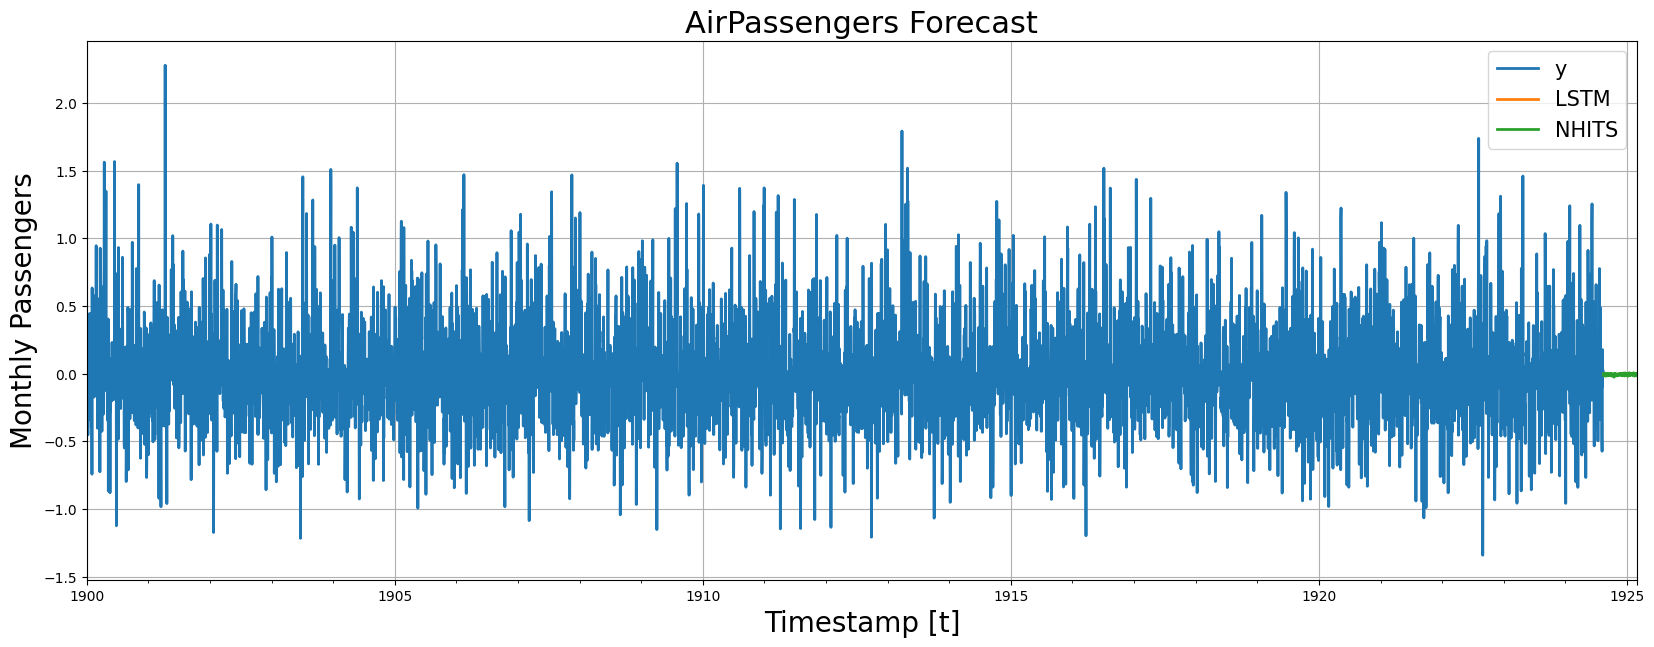

In [41]:
fig, ax = plt.subplots(1, 1, figsize = (20, 7))
plot_df = pd.concat([train, Y_hat_df]).set_index('ds') # Concatenate the train and forecast dataframes
plot_df[['y', 'LSTM', 'NHITS']].plot(ax=ax, linewidth=2)

ax.set_title('AirPassengers Forecast', fontsize=22)
ax.set_ylabel('Monthly Passengers', fontsize=20)
ax.set_xlabel('Timestamp [t]', fontsize=20)
ax.legend(prop={'size': 15})
ax.grid()